# 4th_homework

### Import Section

In [3]:
!pip install scikit-uplift
!pip install causalml
!pip install catboost

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

from sklift.models import SoloModel
from sklift.models import ClassTransformation
from sklift.models import TwoModels

from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds

from catboost import CatBoostClassifier

from IPython.display import Image
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot

     |████████████████████████████████| 401 kB 11.2 MB/s 
     |████████████████████████████████| 326 kB 64.4 MB/s 
     |████████████████████████████████| 1.8 MB 50.9 MB/s 
     |████████████████████████████████| 713 kB 52.4 MB/s 
  Created wheel for causalml: filename=causalml-0.12.0-cp37-cp37m-linux_x86_64.whl size=1041384 sha256=e4b4502a86300e1830866b8e873ad9afb533447b196dc3eebaffc5c0a7c6c21f
  Stored in directory: /root/.cache/pip/wheels/d4/91/27/df00ca0ddd66caea2c34259c66a216abd5c09022638b82d512
  Created wheel for shap: filename=shap-0.37.0-cp37-cp37m-linux_x86_64.whl size=465072 sha256=d15140ec1626c0749f303a5ecee144ba171cd92657fa47c50ecd5b182c596e42
  Stored in directory: /root/.cache/pip/wheels/df/b8/18/2c0a6105152e62dd9a7cf47b5110b9cedb0c8739babdef64b7
Successfully built causalml shap
     |████████████████████████████████| 76.1 MB 51 kB/s 


### Global Settings Section

In [4]:
random_state_global = 0

## 1. скачать набор данных маркетинговых кампаний отсюда https://www.kaggle.com/davinwijaya/customer-retention

In [5]:
# df_data = pd.read_csv(r'data.csv')

from google.colab import files
uploaded = files.upload()

import io
df_data = pd.read_csv(io.BytesIO(uploaded['data.csv']))

Saving data.csv to data.csv


In [6]:
df_data.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0


In [7]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   recency        64000 non-null  int64  
 1   history        64000 non-null  float64
 2   used_discount  64000 non-null  int64  
 3   used_bogo      64000 non-null  int64  
 4   zip_code       64000 non-null  object 
 5   is_referral    64000 non-null  int64  
 6   channel        64000 non-null  object 
 7   offer          64000 non-null  object 
 8   conversion     64000 non-null  int64  
dtypes: float64(1), int64(5), object(3)
memory usage: 4.4+ MB


## 2. там поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.

In [8]:
df_data = df_data.rename(columns={'offer': 'treatment', 'conversion': 'target'})
df_data['treatment'] = df_data['treatment'].apply(lambda x: 0 if x == 'No Offer' else 1)

df_data.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,1,0
1,6,329.08,1,1,Rural,1,Web,0,0
2,7,180.65,0,1,Surburban,1,Web,1,0
3,9,675.83,1,0,Rural,1,Web,1,0
4,2,45.34,1,0,Urban,0,Web,1,0


## 3. сделать разбиение набора данных не тренировочную и тестовую выборки

In [9]:
X_train, X_test, y_train, y_test = train_test_split(df_data.drop(columns='target'), df_data['target'],
                                                   random_state=random_state_global, stratify=df_data['target'],
                                                   train_size=0.8)

## 4. сделать feature engineering на ваше усмотрение (допускается свобода выбора методов)

##### Для решения задачи планируется использовать деревья решений, поэтому предобработка не потребуется.

## 5. провести uplift-моделирование 3 способами: одна модель с признаком коммуникации (S learner), модель с трансформацией таргета (трансформация классов п. 2. 1) и вариант с двумя независимыми моделями

### SoloModel

In [ ]:
%%time

cat_features = ['zip_code', 'channel']
params = {'cat_features': cat_features}

sm = SoloModel(CatBoostClassifier(thread_count=-1, random_state=random_state_global, silent=True))
sm.fit(X_train.drop(columns='treatment'), y_train, X_train['treatment'], estimator_fit_params=params)

Wall time: 14.8 s


SoloModel(estimator=<catboost.core.CatBoostClassifier object at 0x000001AAAAE51A00>)

In [ ]:
%%time

y_pred = sm.predict(X_test.drop(columns='treatment'))

Wall time: 26.9 ms


array([<AxesSubplot:title={'center':'Treatment predictions'}, ylabel='Probability hist'>,
       <AxesSubplot:title={'center':'Control predictions'}>,
       <AxesSubplot:title={'center':'Uplift predictions'}>], dtype=object)

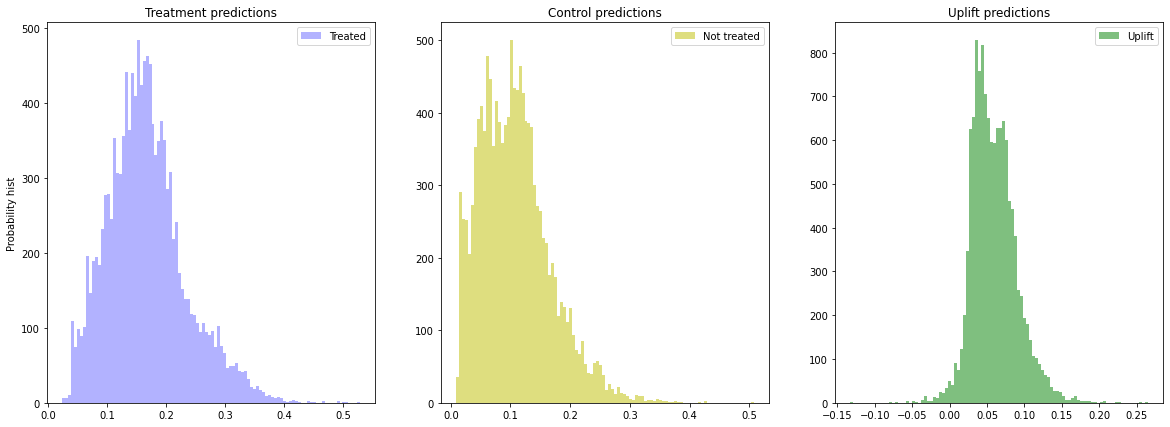

In [ ]:
plot_uplift_preds(sm.trmnt_preds_, sm.ctrl_preds_)

In [ ]:
y_pred = pd.Series(data=y_pred, index=y_test.index)

In [ ]:
df_metrics = pd.DataFrame({
    '10%': uplift_at_k(y_true=y_test, uplift=y_pred, treatment=X_test['treatment'], k=0.1, strategy='by_group'),
    '20%': uplift_at_k(y_true=y_test, uplift=y_pred, treatment=X_test['treatment'], k=0.2, strategy='by_group'),
    '30%': uplift_at_k(y_true=y_test, uplift=y_pred, treatment=X_test['treatment'], k=0.3, strategy='by_group')
}, index=['SoloModel'])

df_metrics

,10%,20%,30%
SoloModel,0.106596,0.0962,0.082448


### ClassTransformation

In [ ]:
%%time

ct = ClassTransformation(CatBoostClassifier(thread_count=-1, random_state=random_state_global, silent=True))
ct.fit(X_train.drop(columns='treatment'), y_train, X_train['treatment'], estimator_fit_params=params)

Wall time: 14.3 s


ClassTransformation(estimator=<catboost.core.CatBoostClassifier object at 0x000001AAAB2B9B80>)

In [ ]:
%%time

y_pred = ct.predict(X_test)

Wall time: 9.97 ms


In [ ]:
df_metrics.loc['ClassTransformation', :] = [
    uplift_at_k(y_true=y_test, uplift=y_pred, treatment=X_test['treatment'], k=0.1, strategy='by_group'),
    uplift_at_k(y_true=y_test, uplift=y_pred, treatment=X_test['treatment'], k=0.2, strategy='by_group'),
    uplift_at_k(y_true=y_test, uplift=y_pred, treatment=X_test['treatment'], k=0.3, strategy='by_group')
]

df_metrics

,10%,20%,30%
SoloModel,0.106596,0.096200,0.082448
ClassTransformation,0.086917,0.082061,0.074738


### TwoModels

In [ ]:
%%time

tm = TwoModels(CatBoostClassifier(thread_count=-1, random_state=random_state_global, silent=True),
              CatBoostClassifier(thread_count=-1, random_state=random_state_global, silent=True))

tm.fit(X_train.drop(columns='treatment'), y_train, X_train['treatment'], params, params)

Wall time: 21.6 s


TwoModels(estimator_ctrl=<catboost.core.CatBoostClassifier object at 0x000001AAAB2CA670>,
          estimator_trmnt=<catboost.core.CatBoostClassifier object at 0x000001AAAB2CA790>)

In [ ]:
%%time

y_pred = tm.predict(X_test)

Wall time: 25.9 ms


array([<AxesSubplot:title={'center':'Treatment predictions'}, ylabel='Probability hist'>,
       <AxesSubplot:title={'center':'Control predictions'}>,
       <AxesSubplot:title={'center':'Uplift predictions'}>], dtype=object)

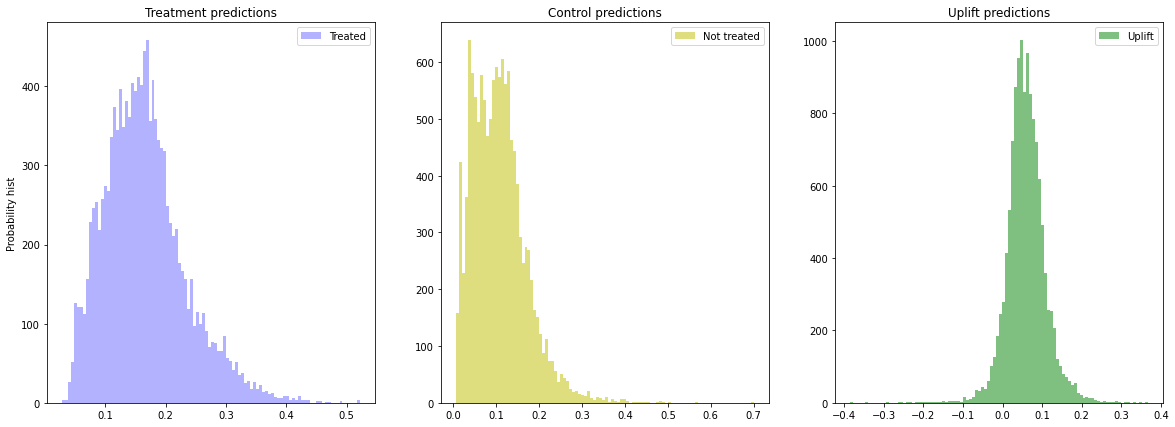

In [ ]:
plot_uplift_preds(tm.trmnt_preds_, tm.ctrl_preds_)

In [ ]:
df_metrics.loc['TwoModels', :] = [
    uplift_at_k(y_true=y_test, uplift=y_pred, treatment=X_test['treatment'], k=0.1, strategy='by_group'),
    uplift_at_k(y_true=y_test, uplift=y_pred, treatment=X_test['treatment'], k=0.2, strategy='by_group'),
    uplift_at_k(y_true=y_test, uplift=y_pred, treatment=X_test['treatment'], k=0.3, strategy='by_group')
]

df_metrics

,10%,20%,30%
SoloModel,0.106596,0.096200,0.082448
ClassTransformation,0.086917,0.082061,0.074738
TwoModels,0.102364,0.088145,0.082602


## 6. в конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% этих 3 моделей

In [ ]:
df_metrics

,10%,20%,30%
SoloModel,0.106596,0.096200,0.082448
ClassTransformation,0.086917,0.082061,0.074738
TwoModels,0.102364,0.088145,0.082602


##### Подход с одной моделью показал наиболее уверенные результаты.

## 7. построить модель UpliftTreeClassifier и попытаться описать словами полученное дерево

In [10]:
features = [col for col in X_train]

X_train_tree = X_train.copy()
X_train_tree = pd.concat([X_train_tree.drop(columns=['zip_code', 'channel']), pd.get_dummies(X_train_tree[['zip_code', 'channel']])], axis=1)

X_train_tree.head()

,recency,history,used_discount,used_bogo,is_referral,treatment,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web
7330,10,125.61,1,0,1,1,0,1,0,0,0,1
39158,11,456.71,1,0,0,1,0,0,1,0,1,0
41586,1,29.99,0,1,1,1,0,0,1,0,1,0
24735,10,29.99,0,1,0,1,0,0,1,0,0,1
58241,10,46.05,1,0,0,1,0,0,1,0,0,1


In [14]:
# %%time

uplift_model = UpliftTreeClassifier(max_depth=8, min_samples_leaf=200, min_samples_treatment=50,
                                    n_reg=100, evaluationFunction='KL', control_name='control')

uplift_model.fit(X_train_tree.drop(columns=['treatment']),
                #  treatment=X_train_tree['treatment'].astype(str),
                 treatment=X_train_tree['treatment'].map({1: 'treatment1', 0: 'control'}).values,
                 y=y_train)

graph = uplift_tree_plot(uplift_model.fitted_uplift_tree, features)
Image(graph.create_png())

Output hidden; open in https://colab.research.google.com to view.

См. изображение "UpliftTreeClassifier.png".

Описание.

## 8. (опционально) для модели S learner (модель с дополнительным признаком коммуникации) построить зависимость таргета (конверсии - поле conversion) от значения uplift: 1) сделать прогноз и получить uplift для тестовой выборки 2) отсортировать тестовую выборку по uplift по убыванию 3) разбить на децили (pandas qcut вам в помощь) 4) для каждого дециля посчитать среднюю conversion

### 1) сделать прогноз и получить uplift для тестовой выборки

In [ ]:
%%time

cat_features = ['zip_code', 'channel']
params = {'cat_features': cat_features}

sm = SoloModel(CatBoostClassifier(thread_count=-1, random_state=random_state_global, silent=True))
sm.fit(X_train.drop(columns='treatment'), y_train, X_train['treatment'], estimator_fit_params=params)

Wall time: 14.5 s


SoloModel(estimator=<catboost.core.CatBoostClassifier object at 0x000001AAAB3F04C0>)

In [ ]:
%%time

y_pred = sm.predict(X_train.drop(columns='treatment'))

Wall time: 75.8 ms


### 2) отсортировать тестовую выборку по uplift по убыванию

In [ ]:
df_dependency = pd.DataFrame(data=y_pred, index=X_train.index, columns=['y_pred'])
df_dependency['target'] = y_train
df_dependency = df_dependency.sort_values(by=['y_pred'], ascending=False)
df_dependency = df_dependency.reset_index(drop=True)

df_dependency.head()

,y_pred,target
0,0.368496,1
1,0.288708,0
2,0.282217,0
3,0.265091,1
4,0.262846,1


### 3) разбить на децили (pandas qcut вам в помощь)

In [ ]:
df_dependency['deciles'] = pd.qcut(df_dependency['y_pred'], q=10)

df_dependency.head()

,y_pred,target,deciles
0,0.368496,1,"(0.097, 0.368]"
1,0.288708,0,"(0.097, 0.368]"
2,0.282217,0,"(0.097, 0.368]"
3,0.265091,1,"(0.097, 0.368]"
4,0.262846,1,"(0.097, 0.368]"


### 4) для каждого дециля посчитать среднюю conversion

In [ ]:
df_dependency.groupby(by=['deciles'])['target'].mean()

deciles
(-0.0921, 0.0274]    0.132031
(0.0274, 0.0349]     0.111523
(0.0349, 0.0413]     0.119531
(0.0413, 0.0482]     0.126953
(0.0482, 0.0559]     0.118750
(0.0559, 0.0644]     0.136523
(0.0644, 0.0727]     0.135156
(0.0727, 0.082]      0.161719
(0.082, 0.097]       0.176172
(0.097, 0.368]       0.249414
Name: target, dtype: float64

##### Для первого дециля наблюдается погрешность: модель спрогнозировала отрицательные значения показателя uplift, однако фактически среднее значение целевой переменной превышает значения некоторых других децилей.
##### Наиболее лучшим образом модель справилась с тремя последними децилями: наивысшие интервалы показателя uplift соответствуют наивысшим средним значениям целевой переменной. Таким образом, модель сумела выявить 30% клиентов, которые с наибольшей вероятностью совершат целевое действие.
##### Данные результаты были получены при работе модели с данными, на которых проводилось обучение модели. Таким образом, качество пронозирования на новых данных может быть ниже.

## 9. (опционально) построить модель UpliftRandomForestClassifier и попытаться описать словами полученное дерево

In [22]:
uplift_model_2 = UpliftRandomForestClassifier(max_depth=8, min_samples_leaf=200, min_samples_treatment=50,
                                              n_reg=100, evaluationFunction='KL', control_name='control')

uplift_model_2.fit(X_train_tree.drop(columns=['treatment']).values,
                #  treatment=X_train_tree['treatment'].astype(str),
                 treatment=X_train_tree['treatment'].map({1: 'treatment1', 0: 'control'}).values,
                 y=y_train.values)

# graph = uplift_tree_plot(uplift_model_2.fitted_uplift_tree, features)
graph = uplift_tree_plot(uplift_model_2.uplift_forest[0].fitted_uplift_tree, features)
Image(graph.create_png())

Output hidden; open in https://colab.research.google.com to view.

См. изображение "UpliftRandomForestClassifier.png".

Описание.